<a href="https://colab.research.google.com/github/kossi-26/Refractory_Machine-Learning/blob/Refactory-final-project/Group%201_data_science_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import joblib
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
np.random.seed(42)
sns.set_theme()

In [3]:
# Load the primary UCI dataset
df = pd.read_csv('data.csv', delimiter=';')
print(f'Original UCI data shape: {df.shape}')

Original UCI data shape: (4424, 37)


In [4]:
# Add simulated Tanzania-specific features
np.random.seed(42)  # For reproducibility

# Rural/Urban divide
df['Location_Type'] = np.random.choice(['Urban', 'Rural'], size=len(df), p=[0.7, 0.3])

# Internet access (lower in rural areas)
df['Internet_Access'] = np.where(
    df['Location_Type'] == 'Urban',
    np.clip(np.random.normal(0.6, 0.2, len(df)), 0.1, 1.0),
    np.clip(np.random.normal(0.3, 0.15, len(df)), 0.05, 0.8)
).round(3)

# Teacher qualifications (lower in rural areas)
df['Teacher_Quality'] = np.where(
    df['Location_Type'] == 'Urban',
    np.clip(np.random.normal(0.75, 0.15, len(df)), 0.4, 1.0),
    np.clip(np.random.normal(0.5, 0.2, len(df)), 0.2, 0.9)
).round(3)

# Distance to school (greater in rural areas)
df['School_Distance_km'] = np.where(
    df['Location_Type'] == 'Urban',
    np.clip(np.random.gamma(2, 0.5, len(df)), 0.5, 5),
    np.clip(np.random.gamma(3, 2, len(df)), 1, 15)
).round(3)

print(f'Enhanced dataset shape: {df.shape}') # New features added - Location_Type, Internet_Access, Teacher_Quality, School_Distance_km
df.head()

Enhanced dataset shape: (4424, 41)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Location_Type,Internet_Access,Teacher_Quality,School_Distance_km
0,1,17,5,171,1,1,122.0,1,19,12,...,0.000000,0,10.8,1.4,1.74,Dropout,Urban,0.415,0.704,1.860
1,1,15,1,9254,1,1,160.0,1,1,3,...,13.666667,0,13.9,-0.3,0.79,Graduate,Rural,0.381,0.792,7.205
2,1,1,5,9070,1,1,122.0,1,37,37,...,0.000000,0,10.8,1.4,1.74,Dropout,Rural,0.249,0.451,9.939
3,1,17,2,9773,1,1,122.0,1,38,37,...,12.400000,0,9.4,-0.8,-3.12,Graduate,Urban,0.557,0.821,0.550
4,2,39,1,8014,0,1,100.0,1,37,38,...,13.000000,0,13.9,-0.3,0.79,Graduate,Urban,0.699,0.692,2.140


In [5]:
# Show basic stats of the enhanced dataset
df.describe().round(3)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Internet_Access,Teacher_Quality,School_Distance_km
count,4424.000,4424.000,4424.000,4424.000,4424.000,4424.000,4424.000,4424.000,4424.000,4424.000,...,4424.000,4424.000,4424.000,4424.000,4424.000,4424.000,4424.000,4424.000,4424.000,4424.000
mean,1.179,18.669,1.728,8856.643,0.891,4.578,132.613,1.873,19.562,22.275,...,8.063,4.436,10.230,0.150,11.566,1.228,0.002,0.511,0.680,2.512
std,0.606,17.485,1.314,2063.566,0.312,10.217,13.188,6.915,15.603,15.343,...,3.948,3.015,5.211,0.754,2.664,1.383,2.270,0.225,0.193,2.956
min,1.000,1.000,0.000,33.000,0.000,1.000,95.000,1.000,1.000,1.000,...,0.000,0.000,0.000,0.000,7.600,-0.800,-4.060,0.050,0.200,0.500
25%,1.000,1.000,1.000,9085.000,1.000,1.000,125.000,1.000,2.000,3.000,...,6.000,2.000,10.750,0.000,9.400,0.300,-1.700,0.344,0.562,0.618
50%,1.000,17.000,1.000,9238.000,1.000,1.000,133.100,1.000,19.000,19.000,...,8.000,5.000,12.200,0.000,11.100,1.400,0.320,0.507,0.700,1.214
75%,1.000,39.000,2.000,9556.000,1.000,1.000,140.000,1.000,37.000,37.000,...,10.000,6.000,13.333,0.000,13.900,2.600,1.790,0.673,0.825,2.941
max,6.000,57.000,9.000,9991.000,1.000,43.000,190.000,109.000,44.000,44.000,...,33.000,20.000,18.571,12.000,16.200,3.700,3.510,1.000,1.000,15.000


## Data Dictionary: Enhanced Student Dropout Prediction Dataset
**Source:** UCI ML Repository + Simulated Specific Features

**Citation:** Realinho, V., Vieira Martins, M., Machado, J., & Baptista, L. (2021)  

**DOI:** https://doi.org/10.24432/C5MC89  

**Students:** 4,424 | **Features:** 36 original + 4 simulated + 1 Target

## Target Variable
| Variable | Values | Description |
|----------|---------|-------------|
| **Target** | 0, 1 | 0=Dropout, 1=Graduate (filtered from original 3-class target) |

## New Simulated Features (Tanzania Context)
| Variable | Type | Values/Range | Description |
|----------|------|--------------|-------------|
| **Location_Type** | Categorical | Urban, Rural | School location type (70% Urban, 30% Rural) |
| **Internet_Access** | Numerical | 0.0-1.0 | Internet access quality score (0.0=None, 1.0=Perfect) |
| **Teacher_Quality** | Numerical | 0.0-1.0 | Teacher qualification score (0.0=Poor, 1.0=Excellent) |
| **School_Distance_km** | Numerical | 0.5-15 km | Distance from home to school in kilometers |

## Original Key Variables
- **Demographics:** Age at enrollment, Gender, Marital status, Nationality

- **Academic Background:** Previous qualification, Admission grade, Course

- **Academic Performance:** Curricular units approved/not approved, Grades

- **Financial:** Tuition fees up to date, Scholarship holder

- **Economic Context:** GDP, Unemployment rate

- **Family Background:** Mother's/Father's qualification and occupation

In [7]:
# Filter to binary targets for modeling
df = df[df['Target'].isin(['Graduate', 'Dropout'])].copy()
df['y'] = df['Target'].map({'Dropout': 0, 'Graduate': 1})
X = df.drop(columns=['Target', 'y'])
y = df['y']

Data Exploration and Visualization

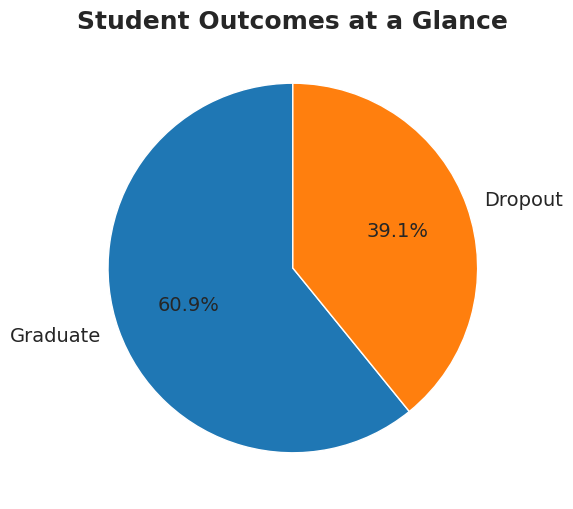

In [8]:
# Pie chart for Target distribution (Overview of outcomes)
plt.figure(figsize=(6, 6))
df['Target'].value_counts().plot.pie(startangle=90,  autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e'], textprops={'fontsize': 14})
plt.title('Student Outcomes at a Glance', fontsize=18, fontweight='bold')
plt.ylabel('')
plt.savefig('target_pie.png', bbox_inches='tight', dpi=150)
plt.show()

Interpretation (Univariate) - This pie chart shows the distribution of student outcomes, with the majority being graduates, indicating a class imbalance where dropouts are less frequent but critical to predict.

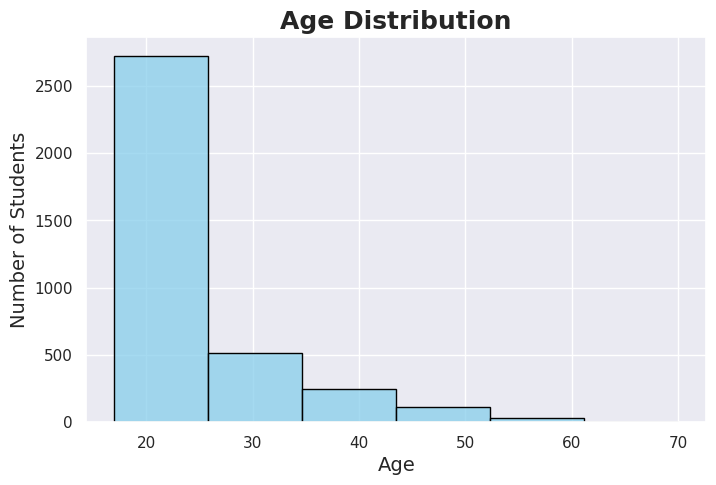

In [9]:
# Age bar plot
plt.figure(figsize=(8, 5))
sns.histplot(df['Age at enrollment'], bins=6, color='skyblue', kde=False, edgecolor='black')
plt.title('Age Distribution', fontsize=18, fontweight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)
plt.savefig('age_bar.png', bbox_inches='tight', dpi=150)
plt.show()

Interpretation (Univariate) - The age distribution is right-skewed, with most students in their 20s, suggesting that many are recent high school graduates. Older students are less common, which may reflect different enrollment or dropout patterns.

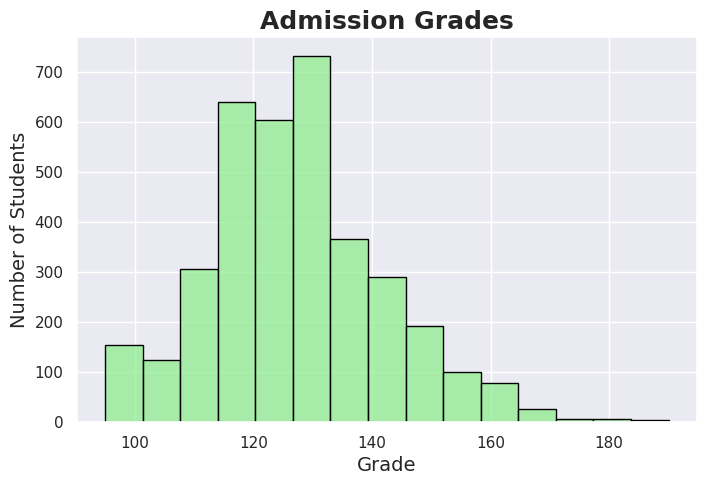

In [10]:
# Admission grade bar plot
plt.figure(figsize=(8, 5))
sns.histplot(df['Admission grade'], bins=15, kde=False, color='lightgreen', edgecolor='black')
plt.title('Admission Grades', fontsize=18, fontweight='bold')
plt.xlabel('Grade', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)
plt.savefig('admission_bar.png', bbox_inches='tight', dpi=150)
plt.show()

Interpretation (Univariate) - Admission grades follow a normal distribution centered around 120-140, with fewer low scores, implying the dataset captures relatively high-performing students overall.

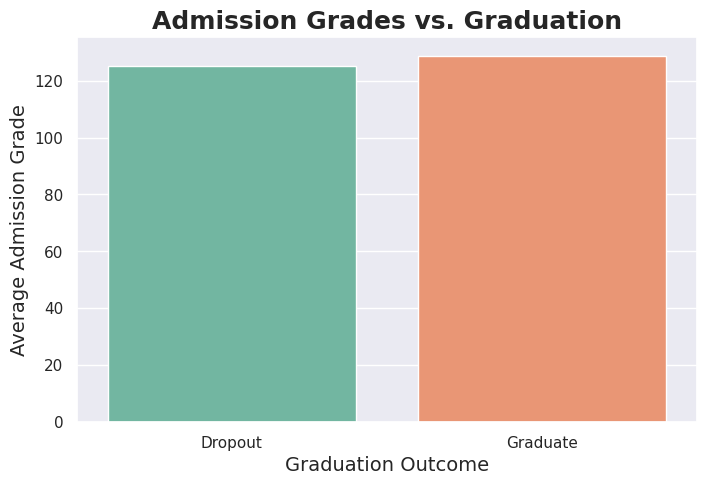

In [11]:
# Bar plot for mean Admission grade by Target
plt.figure(figsize=(8, 5))
sns.barplot(x='Target', y='Admission grade', data=df, palette='Set2', errorbar=None)  # keep default CI or set errorbar='sd' for std
plt.title('Admission Grades vs. Graduation', fontsize=18, fontweight='bold')
plt.xlabel('Graduation Outcome', fontsize=14)
plt.ylabel('Average Admission Grade', fontsize=14)
plt.savefig('admission_by_target_bar.png', bbox_inches='tight', dpi=150)
plt.show()

Interpretation (Bivariate) - Both dropouts and graduates have relatively high admission grades, with only a small difference, suggesting that while academic performance matters, other non-academic factors also play a significant role in determining graduation outcomes

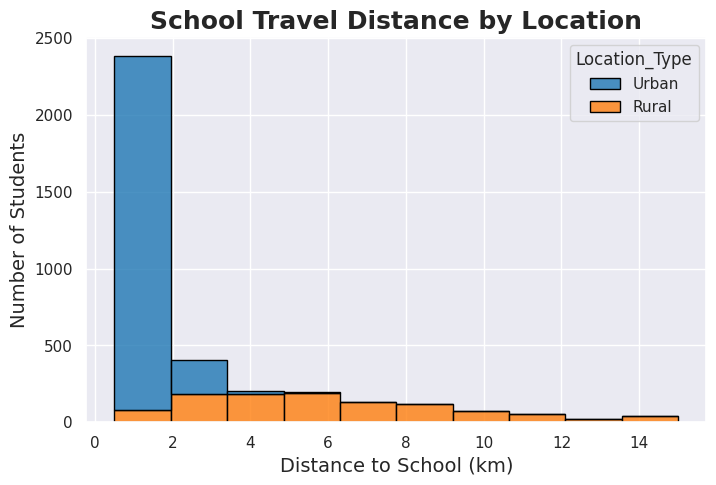

In [12]:
# Stacked bar for School Distance by Location Type
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='School_Distance_km', hue='Location_Type', multiple='stack', palette=['#1f77b4', '#ff7f0e'], bins=10, edgecolor='black', alpha=0.8  )
plt.title('School Travel Distance by Location', fontsize=18, fontweight='bold')
plt.xlabel('Distance to School (km)', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)
plt.savefig('school_distance_stacked.png', bbox_inches='tight', dpi=150)
plt.show()

Interpretation (Multivariate) - Rural students generally travel farther to school compared to urban students, which may increase the risk of dropouts due to accessibility challenges.

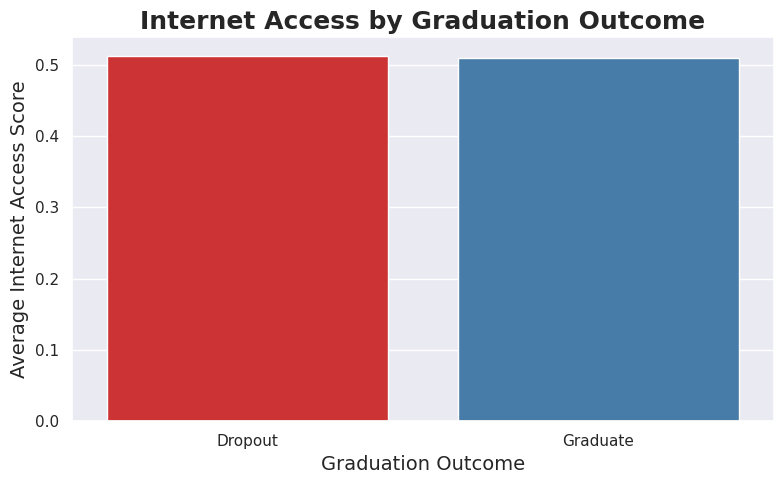

In [13]:
# Bar plot for mean Internet Access by Target
df_filtered = df[df['Target'].isin(['Dropout', 'Graduate'])].copy()
plt.figure(figsize=(8, 5))
sns.barplot(x='Target', y='Internet_Access', data=df_filtered, palette='Set1', errorbar=None)
plt.title('Internet Access by Graduation Outcome', fontsize=18, fontweight='bold')
plt.xlabel('Graduation Outcome', fontsize=14)
plt.ylabel('Average Internet Access Score', fontsize=14)
plt.tight_layout()
plt.savefig('internet_by_target_bar.png', bbox_inches='tight', dpi=150)
plt.show()

Interpretation (Bivariate) - Graduation outcomes show little variation in internet access scores, indicating that factors beyond connectivity are likely more influential.

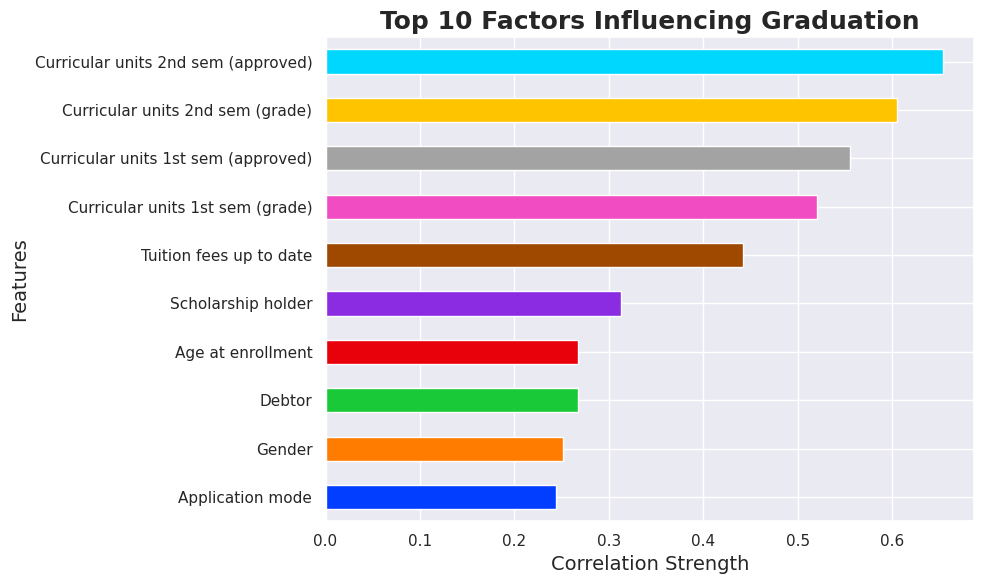

In [14]:
# Horizontal bar plot of top correlations with Target
num_df = df.select_dtypes(include=['float64', 'int64'])
corr_with_target = num_df.corr()['y'].abs().drop('y').sort_values(ascending=False)
top_corr = corr_with_target.head(10)

plt.figure(figsize=(10, 6))
top_corr.sort_values().plot(kind='barh', color=sns.color_palette('bright', len(top_corr)))
plt.title('Top 10 Factors Influencing Graduation', fontsize=18, fontweight='bold')
plt.xlabel('Correlation Strength', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.savefig('top_correlations_barh.png', bbox_inches='tight', dpi=150)
plt.show()

Interpretation (Bivariate) - These are the top 10 features most strongly associated with graduation, showing that academic factors dominate, while non-academic influences also contribute.

In [15]:
# Remove duplicates
df = df.drop_duplicates()
print('Shape after removing duplicates:', df.shape)

Shape after removing duplicates: (3630, 42)


In [16]:
# Handle outliers in key numerical features
for col in ['Age at enrollment', 'Admission grade', 'School_Distance_km']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    print(f'Shape after removing outliers in {col}: {df.shape}')

Shape after removing outliers in Age at enrollment: (3241, 42)
Shape after removing outliers in Admission grade: (3149, 42)
Shape after removing outliers in School_Distance_km: (2780, 42)
